In [1]:
import os
import cv2
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from xml.etree import ElementTree as et
#from torch_snippets import *

from IPython import display 
display.set_matplotlib_formats('svg')

from PIL import Image
from PIL import ImageFont, ImageDraw

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


https://blog.paperspace.com/train-yolov5-custom-data/

In [2]:
class_name_to_id_mapping = {"apple": 0,
                           "banana": 1,
                           "orange": 2}

def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in target: 
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        a.add_patch(rect)
    plt.show()
    
def color_image(img): 
    image = cv2.imread(img)
    image = cv2.cvtColor(image,  cv2.COLOR_BGR2RGB)
    return image 

def read_content(xml_file: str):
    # https://stackoverflow.com/questions/53317592/reading-pascal-voc-annotations-in-python
    tree = et.parse(xml_file)
    root = tree.getroot()
    
    #print(root.find('filename').text)
    yolo_list = []
    list_with_all_boxes = []
    
    filename = root.find('filename').text
    image_w = int(root.find("size/width").text)
    image_h = int(root.find("size/height").text)
    image_c = int(root.find("size/depth").text)
    
    for boxes in root.iter('object'):

        ymin, xmin, ymax, xmax = None, None, None, None
        
        name = boxes.find("name").text
        
        class_id = class_name_to_id_mapping[name]
        
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        
        
        
        b_center_x = (xmin + xmax) / 2 
        b_center_y = (ymin + ymax) / 2
        b_width    = (xmax - xmin)
        b_height   = (ymax - ymin)
        
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        yolo_item = [class_id, b_center_x, b_center_y, b_width, b_height]
        yolo_list.append(yolo_item)

        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)

    return filename, list_with_all_boxes, yolo_list

read_content('../input/fruit-images-for-object-detection/test_zip/test/apple_77.xml')

('apple_77.jpg',
 [[71, 60, 175, 164],
  [12, 22, 105, 111],
  [134, 23, 243, 115],
  [107, 126, 216, 229],
  [207, 138, 298, 229]],
 [[0, 0.41, 0.4890829694323144, 0.3466666666666667, 0.45414847161572053],
  [0, 0.195, 0.2903930131004367, 0.31, 0.388646288209607],
  [0,
   0.6283333333333333,
   0.30131004366812225,
   0.36333333333333334,
   0.4017467248908297],
  [0,
   0.5383333333333333,
   0.7751091703056768,
   0.36333333333333334,
   0.4497816593886463],
  [0,
   0.8416666666666667,
   0.8013100436681223,
   0.30333333333333334,
   0.39737991266375544]])

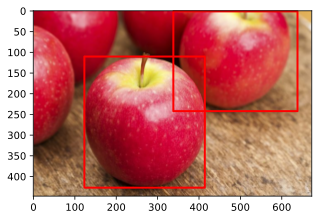

In [3]:
img_path = '../input/fruit-images-for-object-detection/test_zip/test/apple_94.jpg'
anns_path = '../input/fruit-images-for-object-detection/test_zip/test/apple_94.xml'

image = color_image(img_path)
filename, bboxes, _ = read_content(anns_path)

plot_img_bbox(image, bboxes)

# https://www.kaggle.com/code/yerramvarun/fine-tuning-faster-rcnn-using-pytorch/notebook

In [4]:
class CustomDataset(Dataset): 
    def __init__(self, file_dir, width, height, feature_extractor=None): 
        self.width = width 
        self.height = height 
        self.file_dir = file_dir
        self.feature_extractor = feature_extractor
        
        self.img = [i for i in os.listdir(file_dir) if i.endswith('.jpg')]  # Getting only the images 
        self.xml = [f'{i[:-4]}.xml' for i in self.img]  # chaning the image name to xml file. 
        self.classes = ['apple', 'banana', 'orange'] # labels of the images. 
        
    def __len__(self): 
        return len(self.img)
    
    def __getitem__(self, index): 
        img_name = self.img[index]  # indexing the image list 
        ann_name = self.xml[index]  # indexing the xml list 
        
        image_path = f'{self.file_dir}/{img_name}'  # making path for image path 
        ann_path = f'{self.file_dir}/{ann_name}' # making path for anns path 
        
        #image = color_image(image_path) # read the file and give the RGB format of the file! 
        #image_res = image.astype(np.float32)
        #image_res = cv2.resize(image_res, (self.width, self.height), cv2.INTER_AREA)
        #image_res /= 255.0  
        image_res = Image.open(image_path).convert('RGB')#.resize(self.width, self.height)
         
        
        wt = image.shape[1]
        ht = image.shape[0]
        
        tree = et.parse(ann_path)
        root = tree.getroot()
        
        list_with_all_boxes = []
        labels = []
        for boxes in root.iter('object'):
            labels.append(self.classes.index(boxes.find('name').text))

            ymin, xmin, ymax, xmax = None, None, None, None

            ymin = int(boxes.find("bndbox/ymin").text)
            xmin = int(boxes.find("bndbox/xmin").text)
            ymax = int(boxes.find("bndbox/ymax").text)
            xmax = int(boxes.find("bndbox/xmax").text)
            
            # The COCO bounding box format is [top left x position, top left y position, width, height].
            coco_xmin = xmin
            coco_ymin = ymin
            coco_width = xmax - xmin
            coco_height = ymax - ymin
            
            xmin_corr = (xmin/wt)*self.width 
            xmax_corr = (xmax/wt)*self.width 
            ymin_corr = (ymin/ht)*self.height 
            ymax_corr = (ymax/ht)*self.height 
                
            #list_with_single_boxes = [xmin_corr, ymin_corr, xmax_corr, ymax_corr]
            
            coco_list_with_single_boxes = [coco_xmin, coco_ymin, coco_width, coco_height]
            
            line = {'category_id': self.classes.index(boxes.find('name').text), 'bbox': coco_list_with_single_boxes, 'area': 1.0}
            
            #list_with_all_boxes.append(list_with_single_boxes)
            list_with_all_boxes.append(line)
            
        target = {}
        #target['boxes'] = list_with_all_boxes
        #target['labels'] = labels  
        #target['image_id'] = index 
        
        target['annotations'] = list_with_all_boxes
        #target['category_id'] = labels  
        target['image_id'] = index 
        
        
        if self.feature_extractor:
            return feature_extractor(images=image_res, annotations=target, return_tensors="pt")
        else:
            return image_res, target
        

In [5]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small", size=512, max_size=864)

Downloading:   0%|          | 0.00/275 [00:00<?, ?B/s]

In [6]:
file_dir_train = '../input/fruit-images-for-object-detection/train_zip/train'
file_dir_test = '../input/fruit-images-for-object-detection/test_zip/test'

# Getting the dataset 
train_set = CustomDataset(file_dir_train, 224, 224, feature_extractor=feature_extractor)
test_set = CustomDataset(file_dir_test, 224, 224, feature_extractor=feature_extractor)

print(len(train_set), len(test_set))

# Let's get validation test 
train_set, valid_set = torch.utils.data.random_split(train_set, [190, 50])


def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = feature_extractor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    batch = {}
    batch['pixel_values'] = encoding['pixel_values']
    batch['labels'] = labels
    return batch


# Data Loader 
train_dataloader = DataLoader(train_set, batch_size = 1, shuffle = True, num_workers = 1)
val_dataloader = DataLoader(valid_set, batch_size = 1, shuffle = True, num_workers = 1)
test_loader = DataLoader(test_set, batch_size = 1, shuffle = False, num_workers = 1)
#train_dataloader = DataLoader(train_set, collate_fn=collate_fn, batch_size=1, shuffle=True)
#valid_dataloader = DataLoader(valid_set, collate_fn=collate_fn, batch_size=1)
#test_loader = DataLoader(test_set, collate_fn=collate_fn, batch_size=1)


240 60


In [7]:
test_set[9]["pixel_values"].shape
train_set[2]['labels']

[{'boxes': tensor([[0.4420, 0.4981, 0.8270, 0.6734],
          [0.6173, 0.5991, 0.7565, 0.8018],
          [0.3987, 0.3592, 0.7965, 0.4347]]),
  'class_labels': tensor([1, 1, 1]),
  'image_id': tensor([20]),
  'area': tensor([0.1476, 0.1476, 0.1476]),
  'iscrowd': tensor([0, 0, 0]),
  'orig_size': tensor([1332, 2000]),
  'size': tensor([512, 768])}]

(683, 512)
tensor([0.2130, 0.3554, 0.2313, 0.3461])
tensor(66.4787) tensor(93.3808) tensor(224.4793) tensor(270.5765)
tensor([0.2743, 0.6001, 0.2127, 0.2607])
tensor(114.7440) tensor(240.5125) tensor(259.9953) tensor(373.9786)
tensor([0.5653, 0.1495, 0.5067, 0.2117])
tensor(213.0960) tensor(22.3203) tensor(559.1493) tensor(130.7331)
tensor([0.5947, 0.2989, 0.4693, 0.2278])
tensor(245.8800) tensor(94.7473) tensor(566.4346) tensor(211.3594)
tensor([0.5950, 0.3892, 0.5153, 0.2429])
tensor(230.3987) tensor(137.1103) tensor(582.3713) tensor(261.4662)


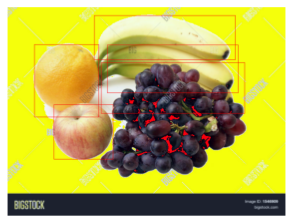

In [8]:
tensor = test_set[9]['pixel_values'][0]
boxes = test_set[9]['labels'][0]['boxes']

tensor = 0.225 * tensor + 0.456

img = T.ToPILImage()(tensor)

print(img.size)
plt.figure(figsize=(5, 5))

draw = ImageDraw.Draw(img)
for box in boxes:
    print(box)
    x1, y1, w_size, h_size = box[0], box[1], box[2], box[3] 
    x_start = (x1 - (w_size/2)) * img.size[0]
    y_start = (y1 - (h_size/2)) * img.size[1]
    x_end = (x_start + w_size * img.size[0]) 
    y_end = (y_start + h_size * img.size[1]) 
    print(x_start, y_start, x_end, y_end)
    draw.rectangle(((x_start, y_start), (x_end, y_end)), outline ="red")
    
plt.imshow(img)
plt.axis('off')
plt.show()

In [9]:
from transformers import DetrConfig, AutoModelForObjectDetection

#model = Detr(lr=2.5e-5, weight_decay=1e-4)
model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-small", num_labels=3, ignore_mismatched_sizes=True)

lr=2.5e-5
weight_decay=1e-4

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
#model

Downloading:   0%|          | 0.00/4.04k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/117M [00:00<?, ?B/s]

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-small and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 384]) in the checkpoint and torch.Size([4, 384]) in the model instantiated
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
if torch.cuda.is_available():  
    model.cuda()

In [11]:
for epoch_num in range(40):
    train_loss = 0
    train_loss_ce = 0
    train_loss_bbox = 0
    valid_loss = 0
    valid_loss_ce = 0
    valid_loss_bbox = 0
    loss = 0
    
    # Train loop   
    model.train()
    #print("Train step")
    for ii, batch in enumerate(iter(train_dataloader)):
        #print(batch["labels"])
        pixel_values = batch['pixel_values'][0]
        
        if torch.cuda.is_available():
            pixel_values = pixel_values.cuda()
            

        if torch.cuda.is_available():  
            labels = [{k: v[0].cuda() for k, v in t.items()} for t in batch['labels']]
        else:
            labels = [{k: v[0] for k, v in t.items()} for t in batch['labels']]
        
        #print(labels)
        
        outputs = model(pixel_values=pixel_values, labels=labels)
        
        #print(outputs)

        loss += outputs.loss
        if (ii+1)%4 == 0:       
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss = 0
        
        #train_loss += loss.item()
        train_loss_ce += outputs.loss_dict['loss_ce'].item()
        train_loss_bbox += outputs.loss_dict['loss_bbox'].item()
        
        #if ii%10 == 0:
        #    print("Iter {}, Loss = {:.4f} {:.4f} {:.4f}".format(ii, loss.item(), outputs.loss_dict['loss_ce'].item(), outputs.loss_dict['loss_bbox'].item()))

    # Valid loop 
    model.eval()
    #print("Eval step")
    for ii, batch in enumerate(iter(val_dataloader)):
        
        if torch.cuda.is_available():
            pixel_values = pixel_values.cuda()
        
        if torch.cuda.is_available():  
            labels = [{k: v[0].cuda() for k, v in t.items()} for t in batch['labels']]
        else:
            labels = [{k: v[0] for k, v in t.items()} for t in batch['labels']]
        
        outputs = model(pixel_values=pixel_values, labels=labels)

        #loss = outputs.loss
        
        #valid_loss += loss.item()
        valid_loss_ce += outputs.loss_dict['loss_ce'].item()
        valid_loss_bbox += outputs.loss_dict['loss_bbox'].item()
        
    print("Epoch {}, Train loss {:.4f}, CE={:.4f}, BBOX={:.4f}".format(epoch_num+1, train_loss, train_loss_ce, train_loss_bbox))
    print("Epoch {}, Valid loss {:.4f}, CE={:.4f}, BBOX={:.4f}".format(epoch_num+1, valid_loss, valid_loss_ce, valid_loss_bbox))

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1, Train loss 0.0000, CE=105.4553, BBOX=12.8383
Epoch 1, Valid loss 0.0000, CE=31.3705, BBOX=16.3379


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 2, Train loss 0.0000, CE=65.2112, BBOX=12.9789
Epoch 2, Valid loss 0.0000, CE=33.3411, BBOX=15.1008


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 3, Train loss 0.0000, CE=50.1376, BBOX=11.2926
Epoch 3, Valid loss 0.0000, CE=45.6130, BBOX=14.9900


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 4, Train loss 0.0000, CE=44.6303, BBOX=11.1868
Epoch 4, Valid loss 0.0000, CE=44.1399, BBOX=15.4802


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 5, Train loss 0.0000, CE=35.8924, BBOX=11.4700
Epoch 5, Valid loss 0.0000, CE=40.9460, BBOX=15.9709


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 6, Train loss 0.0000, CE=26.3696, BBOX=10.4753
Epoch 6, Valid loss 0.0000, CE=49.9006, BBOX=23.9901


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 7, Train loss 0.0000, CE=23.4596, BBOX=10.6208
Epoch 7, Valid loss 0.0000, CE=45.8234, BBOX=12.3692


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 8, Train loss 0.0000, CE=19.6337, BBOX=9.5862
Epoch 8, Valid loss 0.0000, CE=54.6300, BBOX=24.3826


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 9, Train loss 0.0000, CE=16.3595, BBOX=8.9933
Epoch 9, Valid loss 0.0000, CE=53.1204, BBOX=16.1468


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 10, Train loss 0.0000, CE=14.3136, BBOX=8.1574
Epoch 10, Valid loss 0.0000, CE=64.0712, BBOX=19.0388


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 11, Train loss 0.0000, CE=13.7988, BBOX=8.0045
Epoch 11, Valid loss 0.0000, CE=54.4927, BBOX=14.0944


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 12, Train loss 0.0000, CE=13.0250, BBOX=8.0752
Epoch 12, Valid loss 0.0000, CE=73.6873, BBOX=17.4323


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 13, Train loss 0.0000, CE=10.3923, BBOX=7.3929
Epoch 13, Valid loss 0.0000, CE=71.4262, BBOX=14.7956


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 14, Train loss 0.0000, CE=9.3661, BBOX=7.2869
Epoch 14, Valid loss 0.0000, CE=60.6552, BBOX=19.2874


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 15, Train loss 0.0000, CE=7.7788, BBOX=6.7433
Epoch 15, Valid loss 0.0000, CE=55.2451, BBOX=14.3586


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 16, Train loss 0.0000, CE=6.3639, BBOX=6.3704
Epoch 16, Valid loss 0.0000, CE=72.1063, BBOX=14.4768


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 17, Train loss 0.0000, CE=5.7589, BBOX=6.1479
Epoch 17, Valid loss 0.0000, CE=70.9945, BBOX=14.6647


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 18, Train loss 0.0000, CE=4.9579, BBOX=5.8982
Epoch 18, Valid loss 0.0000, CE=73.3806, BBOX=13.1196


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 19, Train loss 0.0000, CE=5.5359, BBOX=5.5487
Epoch 19, Valid loss 0.0000, CE=78.5192, BBOX=15.0562


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 20, Train loss 0.0000, CE=6.1177, BBOX=5.7372
Epoch 20, Valid loss 0.0000, CE=79.8699, BBOX=14.9452


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 21, Train loss 0.0000, CE=5.6523, BBOX=5.5914
Epoch 21, Valid loss 0.0000, CE=66.3023, BBOX=16.0053


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 22, Train loss 0.0000, CE=4.2184, BBOX=5.1013
Epoch 22, Valid loss 0.0000, CE=64.0646, BBOX=12.0690


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 23, Train loss 0.0000, CE=3.7982, BBOX=5.4059
Epoch 23, Valid loss 0.0000, CE=61.1872, BBOX=12.5696


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 24, Train loss 0.0000, CE=3.2914, BBOX=4.8002
Epoch 24, Valid loss 0.0000, CE=76.9135, BBOX=14.4642


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 25, Train loss 0.0000, CE=2.5665, BBOX=4.6945
Epoch 25, Valid loss 0.0000, CE=55.1085, BBOX=14.2066


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 26, Train loss 0.0000, CE=2.0920, BBOX=4.5557
Epoch 26, Valid loss 0.0000, CE=80.4858, BBOX=11.7286


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 27, Train loss 0.0000, CE=2.2199, BBOX=4.5584
Epoch 27, Valid loss 0.0000, CE=79.9636, BBOX=13.1010


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 28, Train loss 0.0000, CE=1.4939, BBOX=4.4658
Epoch 28, Valid loss 0.0000, CE=69.2906, BBOX=15.2450


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 29, Train loss 0.0000, CE=2.5574, BBOX=4.3121
Epoch 29, Valid loss 0.0000, CE=69.6806, BBOX=11.7271


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 30, Train loss 0.0000, CE=3.1342, BBOX=4.7862
Epoch 30, Valid loss 0.0000, CE=82.3534, BBOX=14.8669


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 31, Train loss 0.0000, CE=2.7423, BBOX=4.5617
Epoch 31, Valid loss 0.0000, CE=76.5973, BBOX=12.1262


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 32, Train loss 0.0000, CE=2.3447, BBOX=4.4809
Epoch 32, Valid loss 0.0000, CE=93.1066, BBOX=14.1575


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 33, Train loss 0.0000, CE=2.6130, BBOX=4.5721
Epoch 33, Valid loss 0.0000, CE=93.0797, BBOX=13.1098


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 34, Train loss 0.0000, CE=1.8319, BBOX=5.1353
Epoch 34, Valid loss 0.0000, CE=63.4812, BBOX=14.6757


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 35, Train loss 0.0000, CE=2.1842, BBOX=4.7795
Epoch 35, Valid loss 0.0000, CE=71.6399, BBOX=17.0347


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 36, Train loss 0.0000, CE=2.7107, BBOX=4.4009
Epoch 36, Valid loss 0.0000, CE=78.2357, BBOX=12.4166


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 37, Train loss 0.0000, CE=1.5795, BBOX=4.1379
Epoch 37, Valid loss 0.0000, CE=89.2469, BBOX=13.5934


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 38, Train loss 0.0000, CE=2.3861, BBOX=3.9140
Epoch 38, Valid loss 0.0000, CE=80.0220, BBOX=14.9399


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 39, Train loss 0.0000, CE=1.7438, BBOX=4.4451
Epoch 39, Valid loss 0.0000, CE=82.7371, BBOX=13.4202


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 40, Train loss 0.0000, CE=2.2976, BBOX=4.7801
Epoch 40, Valid loss 0.0000, CE=97.5021, BBOX=13.9655


[{'boxes': tensor([[0.4682, 0.6561, 0.6255, 0.6878],
        [0.1986, 0.6561, 0.3900, 0.6878]]), 'class_labels': tensor([1, 1]), 'image_id': tensor([170]), 'area': tensor([0.4581, 0.4581]), 'iscrowd': tensor([0, 0]), 'orig_size': tensor([ 756, 1100]), 'size': tensor([512, 744])}]
(744, 512)
21 114 161 576 511 0.9818378 1
45 160 116 399 425 0.4759784 1
54 336 165 594 505 0.46407938 1
93 2 161 300 510 0.99244374 1


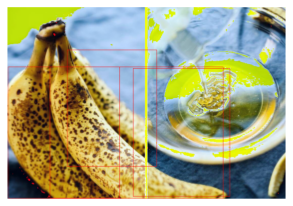

In [12]:
def test_pred(i, set, thr=0.4):
    batch = set[i]
    pixel_values = batch['pixel_values']#[0]
    outputs = model(pixel_values=pixel_values.cuda())

    #outputs
    print(batch['labels'])

    outputs_softmax = torch.softmax(outputs.logits.detach(), dim=-1)[0, :, :-1]
    probs = torch.max(outputs_softmax, dim=-1).values.cpu()
    pred_class = torch.max(outputs_softmax, dim=-1).indices.cpu()

    tensor = pixel_values[0].cpu()
    boxes = outputs.pred_boxes[0].cpu().detach().numpy()

    tensor = 0.225 * tensor + 0.456

    img = T.ToPILImage()(tensor)

    print(img.size)
    plt.figure(figsize=(5, 5))

    draw = ImageDraw.Draw(img)
    for n, box in enumerate(boxes):
        #print(box)
        x1, y1, w_size, h_size = box[0], box[1], box[2], box[3] 
        x_start = (x1 - (w_size/2)) * img.size[0]
        y_start = (y1 - (h_size/2)) * img.size[1]
        x_end = (x_start + w_size * img.size[0]) 
        y_end = (y_start + h_size * img.size[1]) 

        if probs[n]>thr:
            print(n, int(x_start), int(y_start), int(x_end), int(y_end), probs[n].numpy(), pred_class[n].numpy())
            draw.rectangle(((x_start, y_start), (x_end, y_end)), outline ="red")

    plt.imshow(img)
    plt.axis('off')
    plt.show()
test_pred(0, train_set)

[{'boxes': tensor([[0.4111, 0.5234, 0.8044, 0.7299]]), 'class_labels': tensor([2]), 'image_id': tensor([53]), 'area': tensor([1.3054]), 'iscrowd': tensor([0]), 'orig_size': tensor([448, 450]), 'size': tensor([512, 514])}]
(514, 512)
54 5 77 416 459 0.988663 2


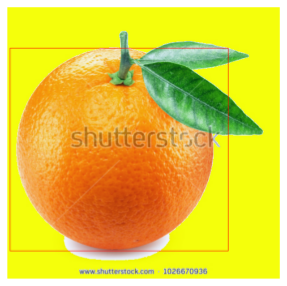

[{'boxes': tensor([[0.3795, 0.6487, 0.5045, 0.6385],
        [0.7114, 0.6093, 0.4545, 0.6472]]), 'class_labels': tensor([2, 2]), 'image_id': tensor([169]), 'area': tensor([2.2255, 2.2255]), 'iscrowd': tensor([0, 0]), 'orig_size': tensor([343, 440]), 'size': tensor([512, 656])}]
(656, 512)
7 316 144 613 475 0.9978592 2
21 79 169 415 499 0.99673414 2


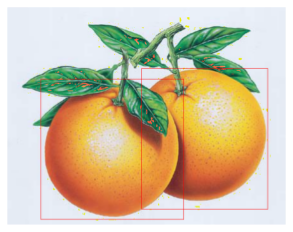

[{'boxes': tensor([[0.5481, 0.6634, 0.3032, 0.4163]]), 'class_labels': tensor([2]), 'image_id': tensor([226]), 'area': tensor([3.9670]), 'iscrowd': tensor([0]), 'orig_size': tensor([257, 343]), 'size': tensor([512, 683])}]
(683, 512)
19 269 235 477 441 0.9921256 2


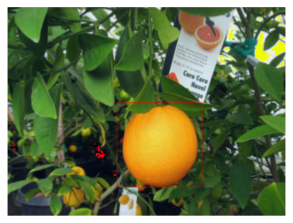

[{'boxes': tensor([[0.4141, 0.2347, 0.6281, 0.1435],
        [0.4203, 0.2984, 0.6187, 0.2452],
        [0.4352, 0.4024, 0.6203, 0.3371],
        [0.5914, 0.4847, 0.5484, 0.4371]]), 'class_labels': tensor([1, 1, 1, 1]), 'image_id': tensor([147]), 'area': tensor([0.6813, 0.6813, 0.6813, 0.6813]), 'iscrowd': tensor([0, 0, 0, 0]), 'orig_size': tensor([620, 640]), 'size': tensor([512, 528])}]
(528, 512)
34 60 89 382 216 0.99988365 1
39 51 81 383 159 0.9974732 1
56 167 136 458 362 0.99970883 1
76 67 121 395 293 0.99914896 1


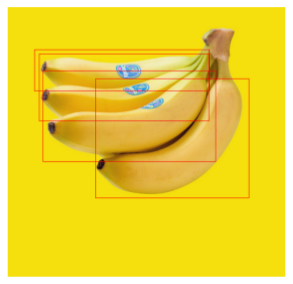

[{'boxes': tensor([[0.4095, 0.2804, 0.2116, 0.3392],
        [0.6333, 0.3696, 0.1921, 0.3558],
        [0.6293, 0.6933, 0.2401, 0.3600]]), 'class_labels': tensor([2, 2, 2]), 'image_id': tensor([105]), 'area': tensor([0.1819, 0.1819, 0.1819]), 'iscrowd': tensor([0, 0, 0]), 'orig_size': tensor([1200, 1999]), 'size': tensor([512, 852])}]
(852, 512)
19 257 57 437 231 0.98996675 2
58 459 97 622 279 0.99783176 2
73 437 264 636 420 0.9570469 2
86 434 96 619 415 0.5197347 2


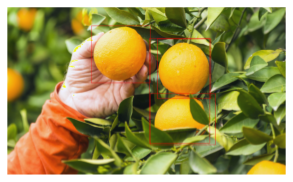

[{'boxes': tensor([[0.5445, 0.5864, 0.8016, 0.7901]]), 'class_labels': tensor([2]), 'image_id': tensor([77]), 'area': tensor([0.6395]), 'iscrowd': tensor([0]), 'orig_size': tensor([648, 640]), 'size': tensor([518, 512])}]
(512, 518)
54 71 100 483 510 0.99757975 2


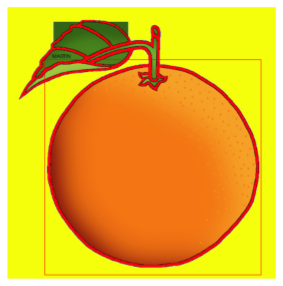

[{'boxes': tensor([[0.4950, 0.6015, 0.6900, 0.7969]]), 'class_labels': tensor([0]), 'image_id': tensor([153]), 'area': tensor([3.8449]), 'iscrowd': tensor([0]), 'orig_size': tensor([261, 300]), 'size': tensor([512, 588])}]
(588, 512)
94 86 105 492 514 0.99550545 0


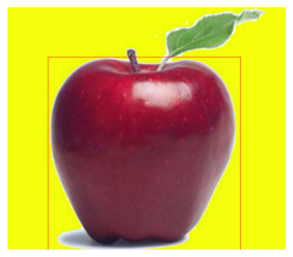

[{'boxes': tensor([[0.6496, 0.5104, 0.4957, 0.7292],
        [0.2650, 0.4417, 0.4274, 0.7000]]), 'class_labels': tensor([0, 0]), 'image_id': tensor([62]), 'area': tensor([4.5462, 4.5462]), 'iscrowd': tensor([0, 0]), 'orig_size': tensor([240, 351]), 'size': tensor([512, 748])}]
(748, 512)
73 298 71 667 450 0.9959591 0
79 35 50 355 406 0.99917245 0


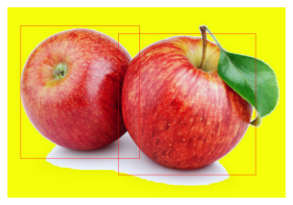

[{'boxes': tensor([[0.6000, 0.6560, 0.3440, 0.3520],
        [0.4880, 0.6100, 0.3120, 0.3640]]), 'class_labels': tensor([2, 2]), 'image_id': tensor([106]), 'area': tensor([4.1943, 4.1943]), 'iscrowd': tensor([0, 0]), 'orig_size': tensor([250, 250]), 'size': tensor([512, 512])}]
(512, 512)
26 171 220 326 395 0.97155476 2
62 169 221 327 395 0.9033748 2
98 216 247 394 424 0.995593 2


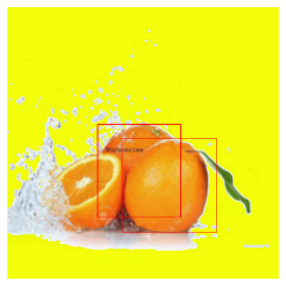

In [13]:
for i in range(11, 20):
    test_pred(i, train_set)

[{'boxes': tensor([[0.4861, 0.5591, 0.7258, 0.8818]]), 'class_labels': tensor([1]), 'image_id': tensor([90]), 'area': tensor([1.4325]), 'iscrowd': tensor([0]), 'orig_size': tensor([406, 722]), 'size': tensor([486, 864])}]
(864, 486)
76 114 166 730 456 0.9995772 1


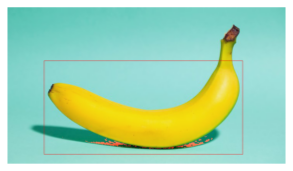

[{'boxes': tensor([[0.5120, 0.5204, 0.7981, 0.7909]]), 'class_labels': tensor([2]), 'image_id': tensor([181]), 'area': tensor([1.5148]), 'iscrowd': tensor([0]), 'orig_size': tensor([416, 416]), 'size': tensor([512, 512])}]
(512, 512)
13 73 57 468 460 0.9996346 2


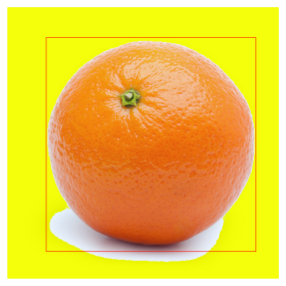

[{'boxes': tensor([[0.2700, 0.5293, 0.4000, 0.6209],
        [0.6967, 0.5458, 0.4233, 0.6794]]), 'class_labels': tensor([2, 2]), 'image_id': tensor([85]), 'area': tensor([1.6958, 1.6958]), 'iscrowd': tensor([0, 0]), 'orig_size': tensor([393, 600]), 'size': tensor([512, 781])}]
(781, 512)
7 385 104 706 435 0.9963541 2
92 58 113 370 439 0.9989452 2


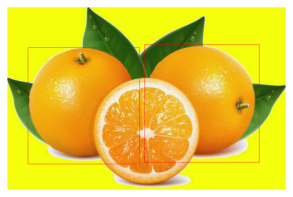

[{'boxes': tensor([[0.4275, 0.3732, 0.3025, 0.4521],
        [0.6913, 0.4894, 0.2825, 0.4539],
        [0.4256, 0.6702, 0.7163, 0.5319]]), 'class_labels': tensor([2, 0, 1]), 'image_id': tensor([3]), 'area': tensor([0.8238, 0.8238, 0.8238]), 'iscrowd': tensor([0, 0, 0]), 'orig_size': tensor([564, 800]), 'size': tensor([512, 726])}]
(726, 512)
7 394 135 608 367 0.9027547 0
19 196 74 431 321 0.99602365 2
56 43 187 571 466 0.42985302 1
91 59 222 576 466 0.9977943 1


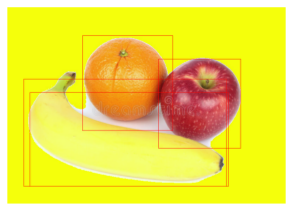

[{'boxes': tensor([[0.7282, 0.6740, 0.5379, 0.6520]]), 'class_labels': tensor([0]), 'image_id': tensor([13]), 'area': tensor([0.2395]), 'iscrowd': tensor([0]), 'orig_size': tensor([1046, 1400]), 'size': tensor([512, 685])}]
(685, 512)
98 322 174 682 511 0.8464726 0


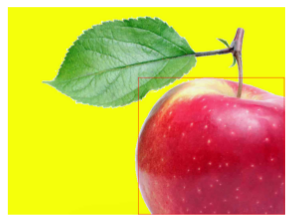

[{'boxes': tensor([[0.3411, 0.4533, 0.5222, 0.6912]]), 'class_labels': tensor([0]), 'image_id': tensor([135]), 'area': tensor([2.1015]), 'iscrowd': tensor([0]), 'orig_size': tensor([353, 450]), 'size': tensor([512, 652])}]
(652, 512)
21 59 67 377 391 0.9964876 0


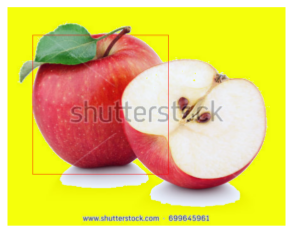

[{'boxes': tensor([[0.4327, 0.4198, 0.4638, 0.4396]]), 'class_labels': tensor([2]), 'image_id': tensor([129]), 'area': tensor([0.1550]), 'iscrowd': tensor([0]), 'orig_size': tensor([1390, 1300]), 'size': tensor([547, 512])}]
(512, 547)
19 100 98 342 371 0.9987863 2


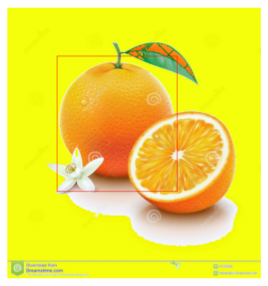

[{'boxes': tensor([[0.3589, 0.6000, 0.4406, 0.6594],
        [0.5865, 0.4344, 0.3375, 0.5094]]), 'class_labels': tensor([0, 0]), 'image_id': tensor([55]), 'area': tensor([0.6400, 0.6400]), 'iscrowd': tensor([0, 0]), 'orig_size': tensor([640, 960]), 'size': tensor([512, 768])}]
(768, 512)
21 100 136 437 469 0.99663323 0
58 306 90 575 364 0.8590582 2


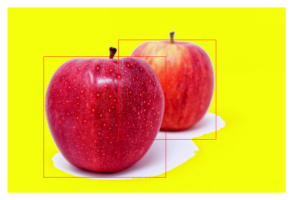

[{'boxes': tensor([[0.6761, 0.5216, 0.5144, 0.7899]]), 'class_labels': tensor([0]), 'image_id': tensor([51]), 'area': tensor([0.2920]), 'iscrowd': tensor([0]), 'orig_size': tensor([ 947, 1320]), 'size': tensor([512, 713])}]
(713, 512)
62 299 71 647 454 0.99923325 0


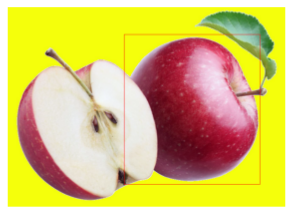

In [14]:
for i in range(21, 30):
    test_pred(i, valid_set)